# Image classification - Open Problem


## Introduction

Cette partie vise à apprendre à classer les types d'occupation du sol avec de petites images satellites.

C'est problème ouvert, vous avez le droit d'utiliser n'importe quel modèle ou architecture, l'objectif est de d'obtenir le meilleur score possible.


## Setup

In [12]:
import numpy as np
import torch
import matplotlib.pyplot as plt

## Prepare the data

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device :", device)

device : cuda:0


In [14]:
#Loading the dataset
!wget -nv https://cerfacs.fr/opendata/cours/data/TRAIN.tar
!wget -nv https://cerfacs.fr/opendata/cours/data/y_train.npy

2023-01-06 10:50:44 URL:https://cerfacs.fr/opendata/cours/data/TRAIN.tar [44851200/44851200] -> "TRAIN.tar.2" [1]
2023-01-06 10:50:44 URL:https://cerfacs.fr/opendata/cours/data/y_train.npy [1600128/1600128] -> "y_train.npy.2" [1]


In [15]:
#Using tarfile to create np arrays
import tarfile
import numpy as np
from PIL import Image

def extract_files(dataset):
  tar = tarfile.open(dataset+'.tar', 'r')
  names = tar.getmembers()[:]
  images = [tar.extractfile(name) for name in names]

  return (np.array([np.array(Image.open(image)) for image in images]))

X_train = extract_files('TRAIN')

y_train = np.load('y_train.npy')

In [16]:
X_val=X_train[:1000,...]
y_val=y_train[:1000,]

X_train=X_train[1000:,...]
y_train=y_train[1000:,]

In [17]:
#One Hot Encoding data
from sklearn.preprocessing import OneHotEncoder
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)

print (f"Shape before OHE : {y_train.shape}\n")
encoder = OneHotEncoder()
y_train = encoder.fit_transform(y_train).toarray()
print (f"Shape after OHE : {y_train.shape}")
print (f"Example of label OHE : {y_train[0]}")

Shape before OHE : (19000, 1)

Shape after OHE : (19000, 10)
Example of label OHE : [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [18]:
y_train.shape, X_train.shape

((19000, 10), (19000, 64, 64, 3))

In [19]:
y_train.shape, X_train.shape, y_val.shape, X_val.shape

((19000, 10), (19000, 64, 64, 3), (1000, 1), (1000, 64, 64, 3))

In [25]:
import torch
import numpy as np
from torch.utils.data import Dataset

class LandCoverDataset(Dataset):

    def __init__(self,data,labels, transform=None):

        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):

        X = self.data[idx,...]
        y = self.labels[idx,...]
        
        if self.transform:
            X = self.transform(X)
        
        return X, y


import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.ToTensor()])

batch_size = 4

trainset = LandCoverDataset(X_train, y_train, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

valset = LandCoverDataset(X_val, y_val, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,shuffle=False, num_workers=2)

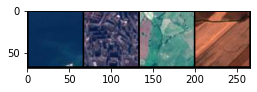

In [26]:
def imshow(img):
    npimg = img.numpy()
    plt.figure(figsize=(4,8*2))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

In [27]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.fc1 = nn.Linear(32 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [28]:
import torch.optim as optim
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [29]:
import time
n_epochs = 100
history={}
history['train_accs'] = []
history['val_accs'] = []
for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    correct = 0
    total = 0
    t1 = time.time()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == torch.max(labels.data, 1)[1]).sum().item()

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print(f'[epoch={epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f} | accuracy {100 * correct / total} %')
            last_acc = 100 * correct / total
            running_loss = 0.0
            correct = 0
            total = 0
    print(f'time={time.time()-t1:.1f}s')
    history['train_accs'] += [last_acc]
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in valloader:
            images, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == torch.max(labels.data, 1)[1]).sum().item()
    history['val_accs'] += [100 * correct / total]
    print(f'Accuracy on validation dataset: {100 * correct / total} %')

[epoch=1,   200] loss: 0.230 | accuracy 10.75 %
[epoch=1,   400] loss: 0.230 | accuracy 11.625 %
[epoch=1,   600] loss: 0.230 | accuracy 11.375 %
[epoch=1,   800] loss: 0.230 | accuracy 11.75 %
[epoch=1,  1000] loss: 0.229 | accuracy 11.375 %
[epoch=1,  1200] loss: 0.229 | accuracy 12.5 %
[epoch=1,  1400] loss: 0.222 | accuracy 14.875 %
[epoch=1,  1600] loss: 0.199 | accuracy 21.75 %
[epoch=1,  1800] loss: 0.187 | accuracy 25.25 %
[epoch=1,  2000] loss: 0.182 | accuracy 26.25 %
[epoch=1,  2200] loss: 0.177 | accuracy 27.375 %
[epoch=1,  2400] loss: 0.178 | accuracy 27.0 %
[epoch=1,  2600] loss: 0.174 | accuracy 28.875 %
[epoch=1,  2800] loss: 0.172 | accuracy 29.0 %
[epoch=1,  3000] loss: 0.173 | accuracy 30.375 %
[epoch=1,  3200] loss: 0.175 | accuracy 32.75 %
[epoch=1,  3400] loss: 0.170 | accuracy 32.625 %
[epoch=1,  3600] loss: 0.171 | accuracy 36.0 %
[epoch=1,  3800] loss: 0.166 | accuracy 34.125 %
[epoch=1,  4000] loss: 0.165 | accuracy 35.125 %
[epoch=1,  4200] loss: 0.171 | acc

TypeError: ignored

In [ ]:
plt.plot(history['train_accs'],label='Train accuracy')
plt.plot(history['val_accs'],label='Validation accuracy')
plt.legend() 
plt.grid() 
plt.show() 

# Test

In [ ]:
dataiter = iter(valloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{labels[j]:5s}' for j in range(4)))

In [ ]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)